In [1]:

import torch
import torch.optim as optim
import torch
from torch.utils.data import DataLoader
import pandas as pd

import segmentation_models_pytorch as smp

import lightning as L
from lightning.pytorch import Trainer, seed_everything
from lightning.pytorch.loggers import WandbLogger, CSVLogger
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor, Callback
import torchmetrics as tm

from config import Config
from dataset import *
from utils import DiceCELossSplitter, plot_img_label_pred, AggregateTestingResultsCallback
from transforms import ImageVisualizer
import wandb

import monai
from monai.transforms import *

from tabulate import tabulate
import matplotlib.pyplot as plt

seed_everything(99, workers=True)


Seed set to 99


99

In [2]:
# globally set source domains for SVDNA and for dataset preppning
cfg = Config(source_domains = ["Spectralis", "Topcon", "Cirrus"])
cfg.batch_size = 1
cfg.epochs = 100

To change experimental setting, check the following:

- source domains in the OCTDatasetPrep class
- Turn on SVDNA in the config file

In [3]:
train_data, val_data, test_data = OCTDatasetPrep(cfg.train_dir,
                                                 source_domains = cfg.source_domains
                                                ).get_datasets(dataset_split=[0.002, 0.001], use_official_testset=False)

train_dataset = MakeDataset(train_data, cfg.train_transforms)
val_dataset = MakeDataset(val_data, cfg.val_transforms)
test_dataset = MakeDataset(test_data, cfg.test_transforms)

train_loader = DataLoader(train_dataset, batch_size=cfg.batch_size, shuffle=True, num_workers=7, persistent_workers=True)
val_loader = DataLoader(val_dataset, batch_size=cfg.batch_size, shuffle=False, num_workers=7, persistent_workers=True)
test_loader = DataLoader(test_dataset, batch_size=cfg.batch_size, shuffle=False, num_workers=7, persistent_workers=True)

Total dataset length:  4959
Training set: 9
Validation set: 4
Test set: 4946


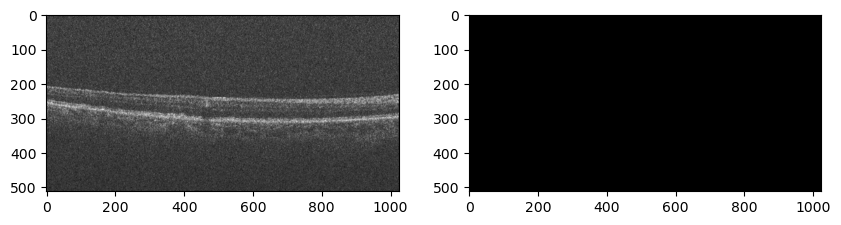

In [4]:
# randomly sample image
random_num = torch.randint(0, len(train_dataset), (1, ))
sample = train_dataset[random_num.item()]

img = sample['img']
mask = sample['masks']

#visualize images in subplots
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img[0], cmap='gray')
ax[1].imshow(mask[1:].permute(1, 2, 0).squeeze(2))
plt.show()

In [5]:
from lightning.pytorch.plugins.environments import SLURMEnvironment
SLURMEnvironment.detect = lambda: False

In [6]:
test_accuracy = tm.classification.Accuracy(task="binary", num_classes=2)

# create dummy tensors of size 1, 4, 512, 1024 where each value is either 0 or 1
# to simulate the output of the model
def create_dummy_tensors():
    y_true = torch.randint(0, 2, (1, 4, 512, 1024))
    y_pred = torch.randint(0, 2, (1, 4, 512, 1024))
    return y_true, y_pred

y, pred = create_dummy_tensors()

# calculate the accuracy of the model
test_accuracy(y, pred)

tensor(0.4998)

In [55]:
class LitUNetPlusPlus(L.LightningModule):
    def __init__(self, cfg, model, experiment_name):
        super().__init__()
        self.cfg = cfg

        self.save_hyperparameters()
        self.model = model
        self.experiment_name = experiment_name

        #self.loss_func = DiceCELossSplitter(include_background=False, sigmoid=True, lambda_ce=0.5)
        
        wandb_logger.experiment.config["include_background"] = "False"
        self.loss_func1 = monai.losses.GeneralizedDiceLoss(include_background=False, sigmoid=True)
        self.loss_func2 = torch.nn.BCEWithLogitsLoss()

        # several metrics
        avg = 'weighted' # weighted: calculates statistics for each label and computes weighted average using their support
        num_classes = 2
        task = 'binary'

        # validation
        self.val_accuracy = tm.classification.Accuracy(task=task, num_classes=num_classes)
        self.val_f1 = tm.classification.F1Score(task=task, num_classes=num_classes)
        self.val_precision = tm.classification.Precision(task=task, average=avg, num_classes=num_classes)
        self.val_recall = tm.classification.Recall(task=task, average=avg, num_classes=num_classes)
        self.val_specificity = tm.classification.Specificity(task=task, average=avg, num_classes=num_classes)

        # test
        self.test_accuracy = tm.classification.Accuracy(task=task, num_classes=num_classes)
        self.test_f1 = tm.classification.F1Score(task=task, num_classes=num_classes)
        self.test_precision = tm.classification.Precision(task=task, average=avg, num_classes=num_classes)
        self.test_recall = tm.classification.Recall(task=task, average=avg, num_classes=num_classes)
        self.test_specificity = tm.classification.Specificity(task=task, average=avg, num_classes=num_classes)


        self.results = {"Model": [], 
                        "Condition": [], 
                        "Accuracy": [], 
                        "F1": [], 
                        "Precision": [], 
                        "Recall": [], 
                        "Specificity": []}
        
        self.conditions = ["Background", "IRF", "SRD", "PED"]

    def training_step(self, batch, batch_idx):
        inputs = batch['img'].to(self.cfg.device)
        #labels = sample['label'].to(device)
        masks = batch['masks'].to(self.cfg.device)

        outputs = self.model(inputs)

        dice_loss = self.loss_func1(outputs, masks)
        ce_loss = self.loss_func2(outputs, masks)
        total_loss = dice_loss + 0.5 * ce_loss
        #dice_loss, ce_loss, total_loss = self.loss_func(outputs, masks)

        #print(f"Total loss: {total_loss.item()} | Dice loss: {dice_loss.item()} | CE loss: {ce_loss.item()}")

        self.log('train_loss_dice', dice_loss.item())
        self.log('train_loss_ce', ce_loss.item())
        self.log('train_loss_total', total_loss.item())

        return total_loss
    
    def validation_step(self, batch, batch_idx):
        inputs = batch['img'].to(self.cfg.device)
        #labels = sample['label'].to(device)
        masks = batch['masks'].to(self.cfg.device)

        outputs = self.model(inputs)

        dice = self.loss_func1(outputs, masks)
        ce = self.loss_func2(outputs, masks)
        total_loss = dice + 0.5 * ce

        # try splitting losses
        #dice, ce, total_loss = self.loss_func(outputs, masks)

        output_to_save = torch.sigmoid(outputs[:5])

        # thresholding
        output_to_save[output_to_save > 0.5] = 1
        output_to_save[output_to_save <= 0.5] = 0

        for i in range(output_to_save.shape[0]):
            img_path = os.path.join(cfg.validation_img_path, f"b{batch_idx}img{i+1}.png")
            cv2.imwrite(img_path, output_to_save[i, 1:, :, :].permute(1, 2, 0).cpu().numpy() * 255)

        self.log('val_loss_total', total_loss)
        self.log('val_loss_dice', dice)
        self.log('val_loss_ce', ce)

        self.log('val_accuracy', self.val_accuracy(outputs, masks.long()))
        self.log('val_f1', self.val_f1(outputs, masks.long()))
        self.log('val_precision', self.val_precision(outputs, masks.long()))
        self.log('val_recall', self.val_recall(outputs, masks.long()))
        self.log('val_specificity', self.val_specificity(outputs, masks.long()))

        return total_loss
    
    def test_step(self, batch, batch_idx):
        inputs = batch['img'].to(self.cfg.device)
        #labels = sample['label'].to(device)
        masks = batch['masks'].to(self.cfg.device)

        outputs = self.model(inputs)
        #loss = self.loss_func(outputs, masks)
        # try splitting losses
        #dice, ce, total_loss = self.loss_func(outputs, masks)

        dice = self.loss_func1(outputs, masks)
        ce = self.loss_func2(outputs, masks)
        total_loss = dice + 0.5 * ce

        torch.sigmoid_(outputs)

        self.log('test_loss_total', total_loss)
        self.log('test_loss_dice', dice)
        self.log('test_loss_ce', ce)

        # calculate metrics for each channel and record separately in pandas df

        for channel in range(outputs.shape[1]):

            outputs_channel = outputs[:, channel, :, :]
            masks_channel = masks[:, channel, :, :]

            accuracy = self.test_accuracy(outputs_channel, masks_channel)
            f1 = self.test_f1(outputs_channel, masks_channel)
            precision = self.test_precision(outputs_channel, masks_channel)
            recall = self.test_recall(outputs_channel, masks_channel)
            specificity = self.test_specificity(outputs_channel, masks_channel)

            self.results["Model"].append(self.experiment_name)
            self.results["Condition"].append(self.conditions[channel])
            self.results["Accuracy"].append(accuracy.item())
            self.results["F1"].append(f1.item())
            self.results["Precision"].append(precision.item())
            self.results["Recall"].append(recall.item())
            self.results["Specificity"].append(specificity.item())
            

        #accuracy = self.test_accuracy(outputs, masks.long())
        #dice = self.test_dice(outputs.long(), masks.long())
        #f1 = self.test_f1(outputs, masks.long())
        #precision = self.test_precision(outputs, masks.long())
        #recall = self.test_recall(outputs, masks.long())
        #specificity = self.test_specificity(outputs, masks.long())



        #self.log('test_accuracy', self.test_accuracy(outputs, masks.long()))
        #self.log('test_f1', self.test_f1(outputs, masks.long()))
        #self.log('test_precision', self.test_precision(outputs, masks.long()))
        #self.log('test_recall', self.test_recall(outputs, masks.long()))
        #self.log('test_specificity', self.test_specificity(outputs, masks.long()))
        #self.log('test_iou', self.test_iou(outputs.long(), masks.long()))
        
        return total_loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.model.parameters(), lr=self.cfg.lr, weight_decay=self.cfg.weight_decay)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=self.cfg.factor, patience=self.cfg.patience_lr)
        return {"optimizer": optimizer, 
                "lr_scheduler": {'scheduler': scheduler, 'monitor': 'val_loss_total'}}
    
    def forward(self, x):
        return self.model(x)
    


############################################################################
experiment_name = "Fully supervised training"
############################################################################
    

model = smp.UnetPlusPlus(**cfg.model_parameters_unetpp)
    
unetpp = LitUNetPlusPlus(cfg, model, experiment_name=experiment_name)

#wandb.finish()
wandb_logger = WandbLogger(project="PracticalWorkinAI", name="Testing eval")

checkpoint_callback = ModelCheckpoint(dirpath=cfg.model_path, monitor='val_loss_total', mode='min')
lr_monitor = LearningRateMonitor(logging_interval='step')
aggregate_testing_results = AggregateTestingResultsCallback()


trainer = L.Trainer(max_epochs=cfg.epochs, 
                    accumulate_grad_batches=8,
                    logger=wandb_logger,
                    default_root_dir=Path(cfg.default_root_dir),
                    log_every_n_steps=2,
                    callbacks=[checkpoint_callback, lr_monitor, aggregate_testing_results],
                    deterministic=True)

/Users/moritz/miniconda3/envs/optima/lib/python3.9/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [54]:
#trainer.fit(unetpp, train_dataloaders=train_loader, val_dataloaders=val_loader)
trainer.test(unetpp, dataloaders=val_loader)

/Users/moritz/miniconda3/envs/optima/lib/python3.9/site-packages/lightning/pytorch/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.


Testing: |          | 0/? [00:00<?, ?it/s]

+--------------------------------------------+----------------------+----------------------+------------------------+------------------------+-----------------------+-----------------------+-----------------------+-----------------------+-------------------------+------------------------+---------------------------+
|                                            | ('Accuracy', 'mean') | ('Accuracy', 'std')  |     ('F1', 'mean')     |     ('F1', 'std')      | ('Precision', 'mean') | ('Precision', 'std')  |  ('Recall', 'mean')   |   ('Recall', 'std')   | ('Specificity', 'mean') | ('Specificity', 'std') |    ('Model', 'first')     |
+--------------------------------------------+----------------------+----------------------+------------------------+------------------------+-----------------------+-----------------------+-----------------------+-----------------------+-------------------------+------------------------+---------------------------+
| ('Fully supervised training', 'Channel 0') |

[{'test_loss_total': 1.1052857637405396,
  'test_loss_dice': 0.7473652362823486,
  'test_loss_ce': 0.7158409357070923}]

## Visualization and results

### Visualize some images and masks

In [7]:
print_some_imgs = False

if print_some_imgs:
    
    transforms_visualize = Compose([cfg.train_transforms, ImageVisualizer(keys=['img', 'label', 'masks'])])
    train_data_raw, _, _ = OCTDatasetPrep(cfg.train_dir, source_domains=cfg.source_domains).get_datasets(use_official_testset=False)
    train_data = MakeDataset(train_data_raw, transforms_visualize)


    for i in range(4):
 
        rand_num = np.random.randint(0, len(train_data))
        sample = train_data[rand_num]
        print(f"Sample {i+1}", 
              "\nImg: ", sample['img'].shape,
              "\nLabel: ", sample['label'].shape,
              "\nMasks: ", sample['masks'].shape)




### Load model and make predictions on random images from validation set

In [8]:
model_checkpoints = os.listdir(cfg.model_path)
print(model_checkpoints)

['untrained_baseline.ckpt']


In [9]:
get_predictions = False

if get_predictions:
    model = LitUNetPlusPlus.load_from_checkpoint(checkpoint_path = cfg.model_path / model_checkpoints[0])
    model.eval()

    for i in range(np.min([5, len(val_dataset)])):
        rand_num = np.random.randint(0, len(val_dataset))
        sample = val_dataset[rand_num]

        img = sample['img'].unsqueeze(0).to(cfg.device)
        mask = sample['masks'].unsqueeze(0).to(cfg.device)

        pred = model(img)
        pred = torch.sigmoid(pred)
        
        # thresholding
        pred[pred > 0.5] = 1
        pred[pred <= 0.5] = 0

        plot_img_label_pred(img, pred, mask)

In [10]:

#model = LitUNetPlusPlus.load_from_checkpoint(checkpoint_path = cfg.model_path / model_checkpoints[0])
#table.append(make_results_table(model, val_dataset, cfg.device, cfg, 'ImageNet pretrained'))

#model = LitUNetPlusPlus.load_from_checkpoint(checkpoint_path = cfg.model_path / model_checkpoints[0])
#table.append(make_results_table(model, val_dataset, cfg.device, cfg, 'Supervised training'))

#model = LitUNetPlusPlus.load_from_checkpoint(checkpoint_path = cfg.model_path / model_checkpoints[0])
#table.append(make_results_table(model, val_dataset, cfg.device, cfg, 'SVDNA source: Spectralis'))

#model = LitUNetPlusPlus.load_from_checkpoint(checkpoint_path = cfg.model_path / model_checkpoints[0])
#table.append(make_results_table(model, val_dataset, cfg.device, cfg, 'SVDNA source: Cirrus'))

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [11]:
# save variable table to text file
#print(tabulate(table, headers='firstrow', tablefmt='github'))
#with open('results.txt', 'w') as f:
#    f.write(tabulate(table, headers='firstrow', tablefmt='latex_raw'))

|             |           | Model   | IRF      | SRF         | PED      |
|-------------|-----------|---------|----------|-------------|----------|
| dice_scores | precision | recall  | accuracy | specificity | f1 score |
| dice_scores | precision | recall  | accuracy | specificity | f1 score |
| dice_scores | precision | recall  | accuracy | specificity | f1 score |
| dice_scores | precision | recall  | accuracy | specificity | f1 score |


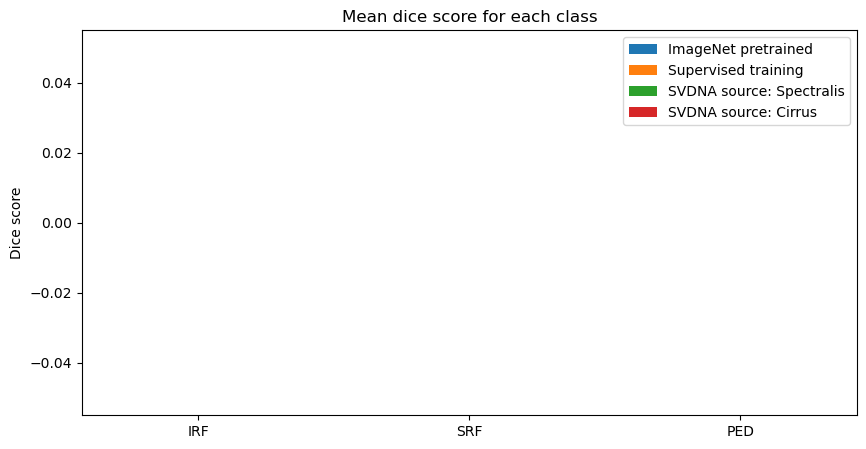

In [9]:
# make a barplot with three bars, one for each class

'''fig, ax = plt.subplots(figsize=(10, 5))

x = np.arange(3)
width = 0.15

for i, model in enumerate(table[1:]):
    ax.bar(x + i*width, model[1:], 0.15, label=model[0])

ax.set_xticks(x + width*1.5)
#ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.set_xticklabels(['IRF', 'SRF', 'PED'])
ax.set_ylabel('Dice score')
ax.set_title('Mean dice score for each class')

ax.legend()
plt.show()'''